In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/" , one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train_X , train_Y , test_X , test_Y = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [4]:
train_X.shape

(55000, 784)

In [5]:
train_X = train_X.reshape(-1,28,28,1) #reshape as images
test_X = test_X.reshape(-1,28,28,1)

In [6]:
X = tf.placeholder("float",[None,28,28,1])
Y = tf.placeholder("float",[None,10])

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

W_C1 = init_weights([3,3,1,32])# 3x3x1 conv, 32 outputs
W_C2 = init_weights([3,3,32,64])# 3x3x32 conv, 64 outputs
W_C3 = init_weights([3, 3, 64, 128])# 3x3x64 conv, 128 outputs

W_FC = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
W_O = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float") #for dropouts as percentage
p_keep_hidden = tf.placeholder("float") 

In [7]:
def model(X, W_C1, W_C2, W_C3, W_FC, W_O, p_keep_conv,p_keep_hidden):
    
    C1 = tf.nn.relu(tf.nn.conv2d(X,W_C1,
                                strides=[1,1,1,1], padding = "SAME")) # 1st convoultion layer shape=(?, 28, 28, 32)
    
    P1 = tf.nn.max_pool(C1,ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding = "SAME" ) # 1st pooling layer shape =(?,14,14,32)
    
    D1 = tf.nn.dropout(P1,p_keep_conv) # 1st dropout at conv
    
    C2 = tf.nn.relu(tf.nn.conv2d(D1,W_C2,
                                strides=[1,1,1,1], padding = "SAME")) # 2nd convoultion layer shape=(?, 14, 14, 62)
    
    P2 = tf.nn.max_pool(C2,ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding = "SAME" ) # 2nd pooling layer shape =(?,7,7,64)
    
    D2 = tf.nn.dropout(P2,p_keep_conv) # 2nd dropout at conv
    
    
    C3 = tf.nn.relu(tf.nn.conv2d(D2,W_C3,
                                strides=[1,1,1,1], padding = "SAME")) # 3rd convoultion layer shape=(?, 7, 7, 128)
    
    P3 = tf.nn.max_pool(C3,ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding = "SAME" ) # 3rd pooling layer shape =(?,4,4,128)
    
    P3 = tf.reshape(P3, [-1, W_FC.get_shape().as_list()[0]])    # reshape to (?, 2048)
    D3 = tf.nn.dropout(P3, p_keep_conv) # 3rd dropout at conv
    
    FC = tf.nn.relu(tf.matmul(D3,W_FC))
    FC = tf.nn.dropout(FC, p_keep_hidden) #droput at fc
    
    output = tf.matmul(FC,W_O)
    
    return output    

In [8]:
Y_pred = model(X, W_C1, W_C2, W_C3, W_FC, W_O, p_keep_conv,p_keep_hidden)

In [9]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred ,labels = Y))
 # compute mean cross entropy (softmax is applied internally)

In [10]:
optimizer = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)

In [11]:
predict_op = tf.argmax(Y_pred, 1) # at predict time, evaluate the argmax of the logistic regression

In [12]:
epochs = 100

with tf.Session() as sess:
    # you need to initialize all variables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        for start, end in zip(range(0, len(train_X), 128), range(128, len(train_X)+1, 128)): 
            sess.run(optimizer,feed_dict={X : train_X[start:end] , Y : train_Y[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
        
        if epoch % 10 == 0:
            print()
            print("epoch : {} and accuracy : {}" .format(epoch, np.mean(np.argmax(test_Y, axis=1) ==
                         sess.run(predict_op, feed_dict={X: test_X, p_keep_conv: 1.0, p_keep_hidden: 1.0}))))
            
            print("testing labels for test data")
            print(sess.run(predict_op, feed_dict={X: test_X,p_keep_conv: 1.0, p_keep_hidden: 1.0}))


epoch : 0 and accuracy : 0.9529
testing labels for test data
[7 2 1 ..., 4 5 6]

epoch : 10 and accuracy : 0.9926
testing labels for test data
[7 2 1 ..., 4 5 6]

epoch : 20 and accuracy : 0.9919
testing labels for test data
[7 2 1 ..., 4 5 6]


KeyboardInterrupt: 

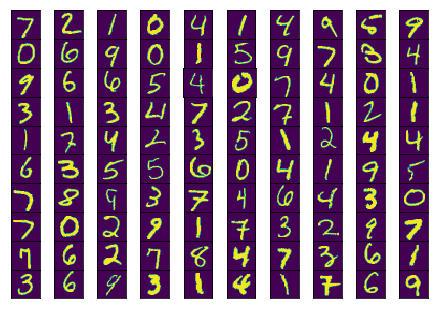

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Visualizing reconstructions
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    #plt.savefig(save_name + '_vis.png')
    plt.show()
    
vis(test_X[:100],"na")